In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('wine').getOrCreate()

In [2]:
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType,DoubleType)
import numpy as np

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv")
col=redData.columns

data_schema = [StructField(col[0],DoubleType(),True),
              StructField(col[1],DoubleType(),True),
              StructField(col[2],DoubleType(),True),
              StructField(col[3],DoubleType(),True),
              StructField(col[4],DoubleType(),True),
              StructField(col[5],DoubleType(),True),
              StructField(col[6],DoubleType(),True),
              StructField(col[7],DoubleType(),True),
              StructField(col[8],DoubleType(),True),
              StructField(col[9],DoubleType(),True),
              StructField(col[10],DoubleType(),True),
              StructField(col[11],IntegerType(),True)]
final_struct = StructType(fields=data_schema)

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv", schema=final_struct)
whiteData = spark.read.format("csv").option("header", "true").load("./data/winequality-white.csv", schema=final_struct)

from pyspark.sql.functions import lit

redData=redData.withColumn("color", lit('red'))
whiteData=whiteData.withColumn("color", lit('white'))

combinedData = redData.union(whiteData)
col=combinedData.columns

In [3]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

qualityModelsDf = combinedData.select(col[0:12])

# Combine all features into one vector named features.
assembler = VectorAssembler(
inputCols=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
              outputCol="features")

# Let's transform the data. 
outputQuality = assembler.transform(qualityModelsDf)

In [4]:
# Let's import the string indexer (similar to the logistic regression exercises).
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexerQuality = StringIndexer(inputCol=col[11], outputCol="QualityIndex")
#embark_encoder = OneHotEncoder(inputCol='QualityIndex',outputCol='QualityVec')
outputQuality = indexerQuality.fit(outputQuality).transform(outputQuality)

# Let's select the two columns we want. Features (which contains vectors), and the predictor.
final_data_quality = outputQuality.select("features",'QualityIndex')

# Split the training and testing set.
train_data_quality,test_data_quality = final_data_quality.randomSplit([0.8,0.2])

In [5]:
# Let's import the relevant classifiers. 
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

rfc5020 = RandomForestClassifier(labelCol='QualityIndex',featuresCol='features',numTrees=50, maxDepth=20, seed=123456789)
rfc100 = RandomForestClassifier(labelCol='QualityIndex',featuresCol='features',numTrees=100, seed=123456789)
rfc1030 = RandomForestClassifier(labelCol='QualityIndex',featuresCol='features',numTrees=10, maxDepth=30, seed=123456789)
rfc = RandomForestClassifier(labelCol='QualityIndex',featuresCol='features', seed=123456789)

In [6]:
rfc5020_model = rfc5020.fit(train_data_quality)
rfc100_model = rfc100.fit(train_data_quality)
rfc1030_model = rfc1030.fit(train_data_quality)
rfc_model = rfc.fit(train_data_quality)

In [7]:
rfc5020_predictions = rfc5020_model.transform(test_data_quality)
rfc100_predictions = rfc100_model.transform(test_data_quality)
rfc1030_predictions = rfc1030_model.transform(test_data_quality)
rfc_predictions = rfc_model.transform(test_data_quality)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator(labelCol="QualityIndex", predictionCol="prediction", metricName="accuracy")

rfc5020_acc = acc_evaluator.evaluate(rfc5020_predictions)
rfc100_acc = acc_evaluator.evaluate(rfc100_predictions)
rfc1030_acc = acc_evaluator.evaluate(rfc1030_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)

print('-'*40)
print('5020: A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc5020_acc*100))
print('-'*40)
print('100: A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc100_acc*100))
print('-'*40)
print('1030: A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc1030_acc*100))
print('-'*40)
print('Baseline: random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))

----------------------------------------
5020: A random forest ensemble has an accuracy of: 67.65%
----------------------------------------
100: A random forest ensemble has an accuracy of: 56.48%
----------------------------------------
1030: A random forest ensemble has an accuracy of: 66.41%
----------------------------------------
Baseline: random forest ensemble has an accuracy of: 55.62%


In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ax1 = plt.subplots()
ax1.set_title("Alcohol: Random Forest Important Variables")
plt.bar(x=["Hybrid Model","Wide Model", "Deep Model", "Baseline Model"],
         height=[rfc5020_acc*100,rfc100_acc*100,rfc1030_acc*100,rfc_acc*100])
plt.ylim((50, 80))
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Accuracy")

Text(0,0.5,'Accuracy')

Text(0,0.5,'Importance')

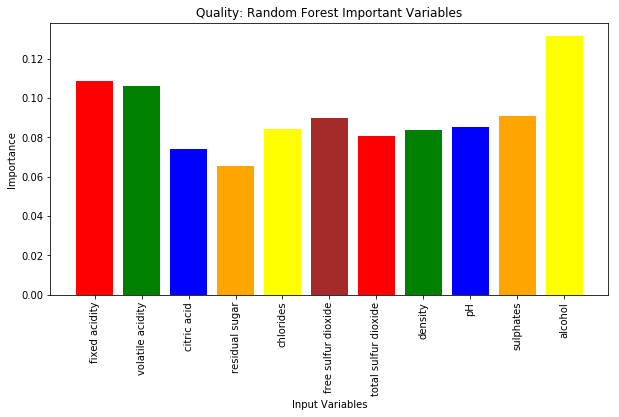

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

fig1, ax1 = plt.subplots()
ax1.set_title("Quality: Random Forest Important Variables")
plt.bar(x=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
         height=rfc5020_model.featureImportances,
       color=["red","green","blue","orange","yellow","brown"])
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Importance")

In [ ]:
#megaTree = RandomForestClassifier(labelCol='QualityIndex',featuresCol='features',numTrees=500, maxDepth=30, seed=123456789)
#megaTree_model = megaTree.fit(train_data_quality)